In [1]:
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from scipy.stats import norm
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import dummy, linear_model, metrics, preprocessing, model_selection
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

In [2]:
donnees1 = pd.read_csv("2015-building-energy-benchmarking.csv")
donnees2 = pd.read_csv("2016-building-energy-benchmarking.csv")

In [3]:
donnees1.shape

(3340, 47)

In [4]:
donnees1.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'human_address': '{""address"": ""405 OLIVE WAY""...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'human_address': '{""address"": ""724 PINE ST"", ...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'human_address': '{""address"": ""1900 5TH AVE"",...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'human_address': '{""address"": ""620 STEWART ST...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'human_address': '{""address"": ""401 LENORA ST""...",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [5]:
donnees2.shape

(3376, 46)

In [6]:
donnees2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [7]:
#détecter la colonne absente dans chacune des data
for c in list(donnees1.columns):
    if c not in list(donnees2.columns):
        print(c)
print("----------")
for c in list(donnees2.columns):
    if c not in list(donnees1.columns):
        print(c)

Location
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
Comment
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes
----------
Address
City
State
ZipCode
Latitude
Longitude
Comments
TotalGHGEmissions
GHGEmissionsIntensity


In [8]:
#adapter les OSEBuildingID
for i, row in donnees1.iterrows():
    donnees1.loc[i, "OSEBuildingID"] = str(row["OSEBuildingID"]) + "_2015"
    
for j, row in donnees2.iterrows():
    donnees2.loc[j, "OSEBuildingID"] = str(row["OSEBuildingID"]) + "_2016"

In [9]:
#Disloquer Location en adresse, cité, etc.
locations = donnees1['Location']
address = []
city = []
state = []
longitude = []
latitude = []
zipCode = []
for i in range(0, len(locations)):
    location = ast.literal_eval(locations[i])
    h_a = location['human_address']
    h_a = ast.literal_eval(h_a)
    address.append(h_a['address'])
    city.append(h_a['city'])
    state.append(h_a['state'])
    zipCode.append(h_a['zip'])
    longitude.append(location['longitude'])
    latitude.append(location['latitude'])
    
donnees1['Address'] = pd.Series(address)
donnees1['City'] = pd.Series(city)
donnees1['State'] = pd.Series(state)
donnees1['ZipCode'] = pd.Series(zipCode)
donnees1['Longitude'] = pd.Series(longitude).astype('float')
donnees1['Latitude'] = pd.Series(latitude).astype('float')

In [10]:
#renommer pour normaliser à donnees2 certaines colonnes 
donnees1 = donnees1.rename(columns={"Comment" : "Comments", "GHGEmissionsIntensity(kgCO2e/ft2)" : "GHGEmissionsIntensity",
                                    "GHGEmissions(MetricTonsCO2e)" : "TotalGHGEmissions"})

In [11]:
#Supprimer les colonnes de valeurs constantes
def del_var_const(data):
    var_const = []
    for f in list(data.columns):
        if len(data[f].value_counts()) == 1:
            data.drop(f, axis=1, inplace=True)
            var_const.append(f)
    print("Colonnes supprimées {}".format(var_const))
    
del_var_const(donnees1)
del_var_const(donnees2)

Colonnes supprimées ['DataYear', 'City', 'State']
Colonnes supprimées ['DataYear', 'City', 'State']


In [12]:
donnees = pd.concat([donnees1, donnees2], axis=0, join='inner', ignore_index=True)#fusion

In [13]:
donnees.shape

(6716, 43)

In [14]:
df = donnees.copy()

In [15]:
df["BuildingType"].value_counts()

NonResidential          2921
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [16]:
#supprimer les batiments d'habitation
indexLR = df[df["BuildingType"] == "Multifamily LR (1-4)"].index
indexMR = df[df["BuildingType"] == "Multifamily MR (5-9)"].index
indexHR = df[df["BuildingType"] == "Multifamily HR (10+)"].index

df.drop(indexLR, inplace = True)
df.drop(indexMR, inplace = True)
df.drop(indexHR, inplace = True)

df.shape

(3318, 43)

In [17]:
#suprimer les variables avec beaucoup de valeurs manquantes
def del_var_useless(data, seuil=1):
    var_useless = []
    for f in list(data.columns):
        if (data[f].isna().sum()/len(data)) >= seuil:
            data.drop(f, axis=1, inplace=True)
            var_useless.append(f)
    print("Colonnes supprimées {}".format(var_useless))

del_var_useless(df, 0.9)

Colonnes supprimées ['YearsENERGYSTARCertified', 'Comments', 'Outlier']


In [18]:
df[df["PropertyGFATotal"] != (df["PropertyGFAParking"] + df["PropertyGFABuilding(s)"])]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,...,NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Address,ZipCode,Longitude,Latitude


In [19]:
df.drop(["PropertyGFATotal"], axis=1, inplace=True)

In [20]:
df.loc[df["Electricity(kBtu)"] < 0, "Electricity(kBtu)"] = np.nan

df.loc[df["TotalGHGEmissions"]<0, "TotalGHGEmissions"] = np.nan

In [21]:
#PrimaryPropertyType
for i, row in df.iterrows():
    f = "PrimaryPropertyType"
    valeur = df.loc[i,f]
    if valeur == "Distribution Center\n":
        df.loc[i,f] = "Distribution Center"
        continue
    if valeur == "Supermarket / Grocery Store":
        df.loc[i,f] = "Supermarket/Grocery Store"
        continue
    if valeur == "Self-Storage Facility\n":
        df.loc[i,f] = "Self-Storage Facility"
        continue
    if valeur == "Restaurant\n":
        df.loc[i,f] = "Restaurant"
        continue
    if valeur == "College/University":
        df.loc[i,f] = "University"
        continue
    if valeur == "Residence Hall/Dormitory":
        df.loc[i,f] = "Residence Hall"
        continue
        
#Neighborhood
for i, row in df.iterrows():
    f = "Neighborhood"
    valeur = df.loc[i,f].strip()
    if valeur == "North":
        df.loc[i,f] = "NORTH"
        continue
    if valeur == "DELRIDGE NEIGHBORHOODS" or valeur == "Delridge":
        df.loc[i,f] = "DELRIDGE"
        continue
    if valeur == "Northwest":
        df.loc[i,f] = "NORTHWEST"
        continue
    if valeur == "Ballard":
        df.loc[i,f] = "BALLARD"
        continue
    if valeur == "Central":
        df.loc[i,f] = "CENTRAL"
        continue        
#DefaultData 
f = "DefaultData"
df[f] = df[f].astype("str")
for i, row in df.iterrows():
    valeur = df.loc[i,f].strip()
    if valeur == "No":
        df.loc[i,f] = "False"
        continue
    if valeur == "Yes":
        df.loc[i,f] = "True"
        continue
    if valeur == "nan":
        df.loc[i,f] = np.nan
#ZipCode
df["ZipCode"] = df["ZipCode"].astype("str")

In [24]:
df["ENERGYSTARScore"].isna().sum()/len(df)

0.3336347197106691

In [153]:
categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

# Prétraitement de la donnée catégorielle
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Prétraitement de la donnée numérique
numerical_transformer = SimpleImputer(strategy='median')

X_train_init, X_test_init = train_test_split(df, test_size=0.2, random_state=0)
SIZE = X_train_init.shape[0]

preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numerical_transformer, numerical_cols)
        ]
    )

imputed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train_init))
imputed_X_test = pd.DataFrame(preprocessor.transform(X_test_init))

imputed_X_train.columns = categorical_cols + numerical_cols
imputed_X_test.columns = categorical_cols + numerical_cols

df = pd.concat([imputed_X_train, imputed_X_test], axis=0, join='inner', ignore_index=True)

In [154]:
for f in numerical_cols:
    df[f] = df[f].astype("float64")

In [155]:
############### Analyse exploratoire  #########################

In [156]:
df.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Longitude,Latitude
count,3318.000000,3318.000000,3318.000000,3318.000000,3318.000000,3.318000e+03,3.318000e+03,3318.000000,3318.000000,3318.000000,...,3.318000e+03,3.318000e+03,3.318000e+03,3.318000e+03,3.318000e+03,3.318000e+03,3318.000000,3318.000000,3318.000000,3318.000000
mean,4.365883,1961.536769,1.117239,4.121760,13303.304702,1.023639e+05,9.427255e+04,23999.700813,7532.051054,67.212779,...,7.974941e+06,4.920650e+05,1.648737e+06,5.626119e+06,1.872721e+04,1.872721e+06,176.705280,1.477737,-122.333051,47.616006
std,2.195304,32.709772,2.219178,6.560238,43596.620504,2.340749e+05,2.251079e+05,49880.816396,15231.024377,23.548830,...,2.065731e+07,5.219646e+06,5.095673e+06,1.738649e+07,7.887994e+04,7.887995e+06,665.567854,2.212131,0.024535,0.048102
min,1.000000,1900.000000,0.000000,0.000000,-2.000000,-5.055000e+04,5.656000e+03,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,-3.382680e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-0.020000,-122.411820,47.499170
25%,2.000000,1930.000000,1.000000,1.000000,0.000000,2.850775e+04,2.575300e+04,11737.000000,5837.000000,61.000000,...,1.329571e+06,0.000000e+00,2.124399e+05,7.253358e+05,0.000000e+00,0.000000e+00,19.775000,0.270000,-122.343357,47.585595
50%,4.000000,1965.000000,1.000000,2.000000,0.000000,4.736800e+04,4.300800e+04,11737.000000,5837.000000,72.000000,...,2.672130e+06,0.000000e+00,4.729222e+05,1.613644e+06,4.866220e+03,4.866055e+05,49.060000,0.770000,-122.333019,47.612313
75%,7.000000,1989.000000,1.000000,4.000000,0.000000,9.447150e+04,8.849000e+04,12353.000000,5837.000000,81.000000,...,7.144437e+06,0.000000e+00,1.425870e+06,4.865271e+06,1.465539e+04,1.465539e+06,138.662500,1.750000,-122.321825,47.649156
max,7.000000,2015.000000,111.000000,99.000000,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,...,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000,-122.258640,47.733870


In [157]:
np.corrcoef(df["NaturalGas(kBtu)"], df["NaturalGas(therms)"])[1,1]

0.9999999999999998

In [158]:
np.corrcoef(df["Electricity(kBtu)"], df["Electricity(kWh)"])[1,1]

0.9999999999999998

In [159]:
#Suppression des colonnes Electricity(kWh) et NaturalGas(therms)
df.drop(["Electricity(kWh)", "NaturalGas(therms)"], axis=1, inplace=True)
df.shape

(3318, 37)

In [160]:
numerical_cols.remove("Electricity(kWh)")
numerical_cols.remove("NaturalGas(therms)")

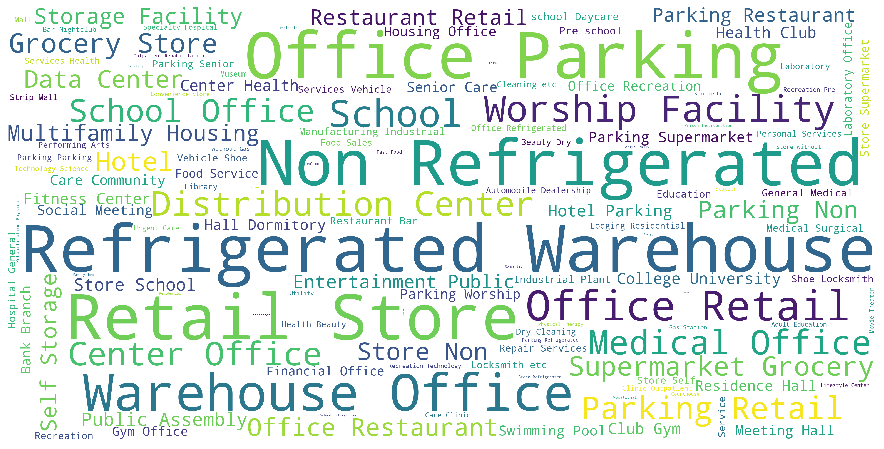

In [161]:
corpus = ' '.join(df["ListOfAllPropertyUseTypes"])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(corpus)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [162]:
def matrice_correlation(features, data):
    X = []
    for f in features:
        X.append(data[f].values)
    
    Mx = np.corrcoef(X)

    mask = np.zeros_like(Mx)
    n = mask.shape[0]
    for i in range(0, n):
        for j in range(0, n):
            if j > i:
                mask[i, j] = True 
            
    with sns.axes_style("white"):
        ax = sns.heatmap(Mx, vmin=0, vmax=1, linewidths=.5,mask=mask, square=True, xticklabels=features, yticklabels=features)

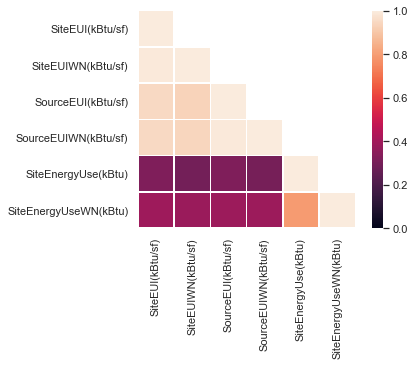

In [163]:
fs = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
      'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']

matrice_correlation(fs, df)

In [164]:
df.drop(["SiteEUIWN(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUseWN(kBtu)"], axis=1, inplace=True)
df.shape

(3318, 34)

In [165]:
numerical_cols.remove("SiteEUIWN(kBtu/sf)")
numerical_cols.remove("SourceEUIWN(kBtu/sf)")
numerical_cols.remove("SiteEnergyUseWN(kBtu)")

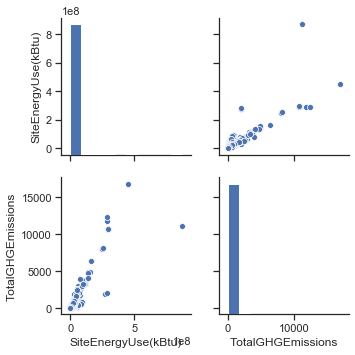

In [166]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, vars=["SiteEnergyUse(kBtu)", "TotalGHGEmissions"])

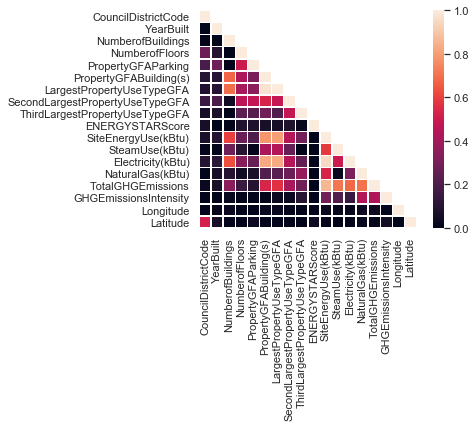

In [167]:
fs = ['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking','PropertyGFABuilding(s)',
      'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','ENERGYSTARScore',
      'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions',
      'GHGEmissionsIntensity','Longitude', 'Latitude']
matrice_correlation(fs, df)

In [168]:
print(df[numerical_cols].skew())

CouncilDistrictCode                -0.001236
YearBuilt                          -0.286742
NumberofBuildings                  39.280544
NumberofFloors                      6.072202
PropertyGFAParking                  5.266699
PropertyGFABuilding(s)             20.513006
LargestPropertyUseTypeGFA          22.588987
SecondLargestPropertyUseTypeGFA     5.961250
ThirdLargestPropertyUseTypeGFA     16.368744
ENERGYSTARScore                    -1.186394
SiteEUI(kBtu/sf)                    3.632941
SourceEUI(kBtu/sf)                  4.667595
SiteEnergyUse(kBtu)                17.501283
SteamUse(kBtu)                     20.064194
Electricity(kBtu)                  19.962189
NaturalGas(kBtu)                   21.321468
TotalGHGEmissions                  14.185609
GHGEmissionsIntensity               4.684568
Longitude                          -0.063584
Latitude                            0.235695
dtype: float64


In [169]:
df_breakpoint = df.copy()

In [213]:
df = df_breakpoint.copy()

In [214]:
print(df[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]].skew())

TotalGHGEmissions      14.185609
SiteEnergyUse(kBtu)    17.501283
dtype: float64


In [215]:
for f in ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]:
    df[f] = np.log1p(df[f])

In [216]:
print(df[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]].skew())

TotalGHGEmissions      0.155362
SiteEnergyUse(kBtu)   -3.320828
dtype: float64


In [217]:
################################################## Emission de CO2 #########################################################

In [218]:
y = df["TotalGHGEmissions"]
X = df.drop(['TotalGHGEmissions', "OSEBuildingID", "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)",
             "GHGEmissionsIntensity", "SiteEnergyUse(kBtu)"], axis=1)

In [219]:
#Transformer les valeurs de la variable DefaultData: True par 1 et False par 0
X.loc[X["DefaultData"] == "True", "DefaultData"] = 1
X.loc[X["DefaultData"] == "False", "DefaultData"] = 0
X["DefaultData"] = X["DefaultData"].astype("float64")

#traiter les variables Electricity, NaturalGas, SteamUse comme binaire; 1 si val > 0 et 0 sinon
X.loc[X["SteamUse(kBtu)"] > 0, "SteamUse(kBtu)"] = 1
X.loc[X["Electricity(kBtu)"] > 0, "Electricity(kBtu)"] = 1
X.loc[X["NaturalGas(kBtu)"] > 0, "NaturalGas(kBtu)"] = 1

In [220]:
X[["DefaultData", "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]][:5]

,DefaultData,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,1.0
4,0.0,1.0,1.0,1.0


In [221]:
#variables catégorielles
def categorical_cols_split(X, num_split):
    categorical_cols_label = []
    categorical_cols_other = []
    for cname in X.columns:
        if X[cname].dtype == "object":
            if X[cname].nunique() > num_split:
                categorical_cols_label.append(cname)
            else:
                categorical_cols_other.append(cname)
    return categorical_cols_label, categorical_cols_other

categorical_cols_label, categorical_cols_other = categorical_cols_split(X, 50)

categorical_cols = categorical_cols_label + categorical_cols_other

#variables numériques
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

In [222]:
X_train = X[:SIZE]
X_test = X[SIZE:]
y_train = y[:SIZE]
y_test = y[SIZE:]

In [223]:
bunch_train = X_train[numerical_cols]
bunch_test =  X_test[numerical_cols]

In [224]:
bunch_train.head()

,DefaultData,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Longitude,Latitude
0,0.0,4.0,1948.0,1.0,1.0,0.0,22778.0,21194.0,12923.0,3720.0,72.0,0.0,1.0,1.0,-122.276776,47.66811
1,0.0,6.0,2000.0,1.0,4.0,36528.0,53472.0,90000.0,11737.0,5837.0,84.0,0.0,1.0,0.0,-122.351580,47.64963
2,0.0,2.0,1963.0,1.0,1.0,0.0,100386.0,50628.0,49758.0,5837.0,72.0,0.0,1.0,1.0,-122.327410,47.56819
3,0.0,7.0,1947.0,1.0,2.0,0.0,22612.0,22612.0,11737.0,5837.0,87.0,0.0,1.0,1.0,-122.403200,47.63927
4,0.0,7.0,1914.0,1.0,4.0,0.0,45500.0,45500.0,11737.0,5837.0,77.0,1.0,1.0,1.0,-122.335200,47.60154


In [225]:
#Label encoder
X_tr = X_train.copy()
X_te = X_test.copy()

label_encoder = LabelEncoder()

for col in categorical_cols_label:
    bunch_train[col] = label_encoder.fit_transform(X_tr[col])
    lists_enc = list(label_encoder.classes_)
    lists_enc_not = []
    for i, row in X_te.iterrows():
        val = X_te.loc[i, col] 
        if val not in lists_enc:
            lists_enc_not.append(val)    
    label_encoder.classes_ = np.array(lists_enc + lists_enc_not)
    bunch_test[col] = label_encoder.transform(X_te[col])

C:\Users\namat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\namat\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [226]:
bunch_test.head()

,DefaultData,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,Electricity(kBtu),NaturalGas(kBtu),Longitude,Latitude,PropertyName,TaxParcelIdentificationNumber,ListOfAllPropertyUseTypes,LargestPropertyUseType,Address,ZipCode
2654,0.0,4.0,1955.0,1.0,2.0,0.0,126394.0,26225.0,11737.0,5837.0,...,1.0,1.0,-122.296123,47.662703,2579,1680,362,48,2514,15
2655,0.0,7.0,2009.0,1.0,3.0,0.0,23241.0,23241.0,11737.0,5837.0,...,1.0,1.0,-122.353210,47.618847,2580,1838,369,55,2515,23
2656,0.0,6.0,1960.0,1.0,1.0,0.0,20678.0,23100.0,11737.0,5837.0,...,1.0,1.0,-122.356740,47.686020,2581,1769,242,24,2516,12
2657,0.0,6.0,1922.0,1.0,3.0,0.0,28820.0,33780.0,11737.0,5837.0,...,1.0,1.0,-122.357070,47.686420,2582,269,142,14,2517,12
2658,0.0,7.0,1968.0,1.0,8.0,62993.0,94948.0,84838.0,15401.0,5837.0,...,1.0,0.0,-122.336395,47.605710,2583,1683,277,24,2518,7


In [227]:
#listes d'encodeurs
OH_encoder = OneHotEncoder(handle_unknown='ignore')#One-Hot-Encoding
CE_encoder = ce.CountEncoder()#Count Encoding
TE_encoder = ce.TargetEncoder(cols=categorical_cols_other)#Target Encoding
CatB_encode = ce.CatBoostEncoder(cols=categorical_cols_other)#CatBoost Encoding

In [228]:
encoder_names = []
encoder_names.append("One hot encoding")
encoder_names.append("Count encoding")
encoder_names.append("Target encoding")
encoder_names.append("CatBoost encoding")

In [229]:
#listes d'estimateurs
lr = Ridge(alpha=1.0)#Linear Regressor Ridge
svr = SVR(kernel="rbf", gamma='scale', C=1.0)#SVM regressor
rf = RandomForestRegressor(max_depth=2, n_estimators=100, random_state=0)#Random Forest
gb = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, loss='ls')#Gradient Boosting

In [230]:
models = []

models.append(lr)
models.append(svr)
models.append(rf)
models.append(gb)

model_names = []
model_names.append("Linear regressor Ridge")
model_names.append("SVM regressor")
model_names.append("Random Forest Regressor")
model_names.append("Gradient Boosting Regressor")

errors_encoding = []

In [231]:
bars = {"Linear regressor Ridge" : [], "SVM regressor": [], "Random Forest Regressor": [],
        "Gradient Boosting Regressor": [], "Total moyen": []}

In [232]:
import time
X_tr = bunch_train.join(X_train[categorical_cols_other])
X_te = bunch_test.join(X_test[categorical_cols_other])

#one hot encoding
sum_error = 0
errors = []
start_time = time.time()
i = 0
for model in models:
    my_pipeline = Pipeline(steps=[('encoder', OH_encoder), ('model', model)])
    my_pipeline.fit(X_tr, y_train)
    y_preds = my_pipeline.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps total d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps total d'execution : 2.621077537536621 secondes
RMSE : 0.9446605034364168


In [233]:
#Count encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

d = pd.concat([ixtr[categorical_cols_other],ixte[categorical_cols_other]], 
              axis=0, join='inner', ignore_index=True)#fusion des lignes des variables à encoder

d2 = pd.concat([bxtr, bxte], axis=0, join='inner', ignore_index=True)#fusion des bunchs train et test

start_time = time.time()
count_encoded = CE_encoder.fit_transform(d[categorical_cols_other])

data = d2.join(count_encoded.add_suffix("_count")) 

X_tr = data[:SIZE]
X_te = data[SIZE:]

sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d'execution : 0.9229955673217773 secondes
RMSE : 1.0026417603104978


In [234]:
#Target encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

start_time = time.time()

TE_encoder.fit(ixtr[categorical_cols_other], y_train)

X_tr = bxtr.join(TE_encoder.transform(ixtr[categorical_cols_other]).add_suffix('_target'))
X_te = bxte.join(TE_encoder.transform(ixte[categorical_cols_other]).add_suffix('_target'))

#print(target_encoded_train)
sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d'execution : 1.0284674167633057 secondes
RMSE : 0.9628449500696181


In [235]:
#CatBoost encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

start_time = time.time()

CatB_encode.fit(ixtr[categorical_cols_other], y_train)
X_tr = bxtr.join(CatB_encode.transform(ixtr[categorical_cols_other]).add_suffix('_CB'))
X_te = bxte.join(CatB_encode.transform(ixte[categorical_cols_other]).add_suffix('_CB'))

sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d execution : 1.1140642166137695 secondes
RMSE : 0.9622661697655096


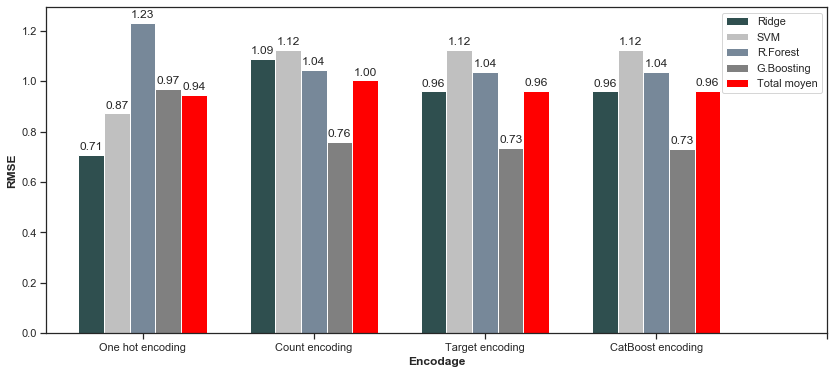

In [236]:
fig, ax = plt.subplots(figsize=(14, 6))
barWidth = 0.15
r1 = np.arange(4)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

rects1 = ax.bar(r1, bars[model_names[0]], color="#2F4F4F", width=barWidth, edgecolor='white', label="Ridge")
rects2 = ax.bar(r2, bars[model_names[1]], color='#C0C0C0', width=barWidth, edgecolor='white', label="SVM")
rects3 = ax.bar(r3, bars[model_names[2]], color='#778899', width=barWidth, edgecolor='white', label="R.Forest")
rects4 = ax.bar(r4, bars[model_names[3]], color='#808080', width=barWidth, edgecolor='white', label="G.Boosting")
rects5 = ax.bar(r5, bars["Total moyen"], color='red', width=barWidth, edgecolor='white', label="Total moyen")


# Add xticks on the middle of the group bars
ax.set_xlabel('Encodage', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_xticks([r + barWidth*2 for r in range(5)])
ax.set_xticklabels(['One hot encoding', 'Count encoding', 'Target encoding', 'CatBoost encoding'])
 
# Create legend & Show graphic
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f'%height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

In [237]:
### ajout le meilleur encodage
X_tr = X_train[categorical_cols_other]
X_te = X_test[categorical_cols_other]

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_tr).toarray())
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_te).toarray())

# Remettre les index des lignes
OH_cols_train.index = X_tr.index
OH_cols_test.index = X_te.index

#création des noms de colonnes
names_cols = []
for k in list(OH_cols_train.columns):
    names_cols.append("OH{}".format(k))
    
#renommer les colonnes    
OH_cols_train.columns = names_cols
OH_cols_test.columns = names_cols

#Ajout dans le bunch de feature
bunch_train = bunch_train.join(OH_cols_train)
bunch_test = bunch_test.join(OH_cols_test)

In [238]:
#Régularisation L1
X = bunch_train.copy()
y = y_train.copy()
regL = Lasso(alpha=0.015).fit(X, y)
model = SelectFromModel(regL, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X.index,columns=X.columns)
# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]
print(list(selected_columns))

(2654, 25)
['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'PropertyName', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'Address', 'ZipCode', 'OH1', 'OH5', 'OH7', 'OH10', 'OH14', 'OH16', 'OH22', 'OH24', 'OH25', 'OH27', 'OH28', 'OH34']


In [239]:
bunch_train_breakpoint = bunch_train.copy()
bunch_test_breakpoint = bunch_test.copy()

In [240]:
bunch_train = bunch_train_breakpoint.copy()
bunch_test = bunch_test_breakpoint.copy()

In [241]:
bunch_train = bunch_train[selected_columns]
bunch_test = bunch_test[selected_columns]

In [242]:
bunch_train.shape

(2654, 25)

In [243]:
std = preprocessing.StandardScaler()

In [244]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

#definir les modèles baselines
start_time = time.time()
dum_mean = dummy.DummyRegressor(strategy='mean')
my_pipeline = Pipeline(steps=[('preprocessor', std), ('model', dum_mean)])
my_pipeline.fit(X_train, y_train)
y_pred_mean = my_pipeline.predict(X_test)
rmse_mean = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))
time_mean = time.time() - start_time

start_time = time.time()
dum_median = dummy.DummyRegressor(strategy='median')
my_pipeline2 = Pipeline(steps=[('preprocessor', std), ('model', dum_median)])
my_pipeline2.fit(X_train, y_train)
y_pred_median = my_pipeline2.predict(X_test)
rmse_median = np.sqrt(metrics.mean_squared_error(y_test, y_pred_median))
time_median = time.time() - start_time

print("RMSE Mean DummyRegressor: %.2f, runtime: %.2fs" % (rmse_mean, time_mean))
print("RMSE Median DummyRegressor: %.2f, runtime: %.2fs" % (rmse_median, time_median))

RMSE Mean DummyRegressor: 1.46, runtime: 0.01s
RMSE Median DummyRegressor: 1.47, runtime: 0.00s


In [250]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_ridge = {'alpha':np.logspace(-10, 10, 100)}
lr = linear_model.Ridge()#linear regression ridge
grid_pred_ridge = model_selection.GridSearchCV(lr, param_grid_ridge, cv=5)

my_pipeline3 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_ridge)])

my_pipeline3.fit(X_train, y_train)

y_pred_linear = my_pipeline3.predict(X_test)

rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear))
time_lr = time.time() - start_time

#récupération des paramètres
lrp = grid_pred_ridge.best_params_["alpha"]

print("RMSE Linear Regression ridge: %.2f, runtime: %.2fs" % (rmse_lr, time_lr))
print("Best params : {}".format(grid_pred_ridge.best_params_))

RMSE Linear Regression ridge: 1.03, runtime: 1.03s
Best params : {'alpha': 210.49041445120218}


In [255]:
X_train = bunch_train.copy()
X_test = bunch_test.copy()

start_time = time.time()
param_grid_rd = {'max_depth' : np.arange(16, 18), 'n_estimators' : np.arange(500, 2000, 500)}
rf = RandomForestRegressor(random_state=0)#random Forest regressor
grid_pred_rf = model_selection.GridSearchCV(rf, param_grid_rd, cv=5)

my_pipeline4 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_rf)])

my_pipeline4.fit(X_train, y_train)

y_pred_rf = my_pipeline4.predict(X_test)

rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
time_rf = time.time() - start_time

#récupération des paramètres
rfparam1 = grid_pred_rf.best_params_["max_depth"]
rfparam2 = grid_pred_rf.best_params_["n_estimators"]

print("RMSE Random Forest: %.2f, runtime: %.2fs" % (rmse_rf, time_rf))
print("Best params : {}".format(grid_pred_rf.best_params_))

RMSE Random Forest: 0.92, runtime: 293.34s
Best params : {'max_depth': 17, 'n_estimators': 1000}


In [263]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_gb ={'n_estimators' : np.arange(1400, 1700, 50), 'max_depth' : np.arange(5,7), 'learning_rate' : [0.05]}
gb = GradientBoostingRegressor(loss='ls')#Gradient boosting regressor
grid_pred_gb = model_selection.GridSearchCV(gb, param_grid_gb, cv=5)

my_pipeline5 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_gb)])

my_pipeline5.fit(X_train, y_train)

y_pred_gb = my_pipeline5.predict(X_test)

rmse_gb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb))
time_gb = time.time() - start_time

#récupération des paramètres
gbparam1 = grid_pred_gb.best_params_["n_estimators"]
gbparam2 = grid_pred_gb.best_params_["max_depth"]
gbparam3 = grid_pred_gb.best_params_["learning_rate"]

print("RMSE Gradient Boosting: %.2f, runtime: %2.fs" % (rmse_gb, time_gb))
print("Best params : {}".format(grid_pred_gb.best_params_))

RMSE Gradient Boosting: 1.24, runtime: 318s
Best params : {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1600}


In [264]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_svm ={'C' : [1e0, 1e1, 1e2, 1e3], 'gamma': np.logspace(-2, 2, 5)}
svm = SVR(kernel="rbf")#SVM regressor
grid_pred_svm = model_selection.GridSearchCV(svm, param_grid_svm, cv=5)

my_pipeline6 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_svm)])

my_pipeline6.fit(X_train, y_train)

y_pred_svm = my_pipeline6.predict(X_test)

rmse_svm = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svm))
time_svm = time.time() - start_time

#récupération des paramètres
svmparam1 = grid_pred_svm.best_params_["C"]
svmparam2 = grid_pred_svm.best_params_["gamma"]

print("RMSE SVM Regressor: %.2f, runtime: %2.fs" % (rmse_svm, time_svm))
print("Best params : {}".format(grid_pred_svm.best_params_))

RMSE SVM Regressor: 1.17, runtime: 85s
Best params : {'C': 10.0, 'gamma': 0.1}


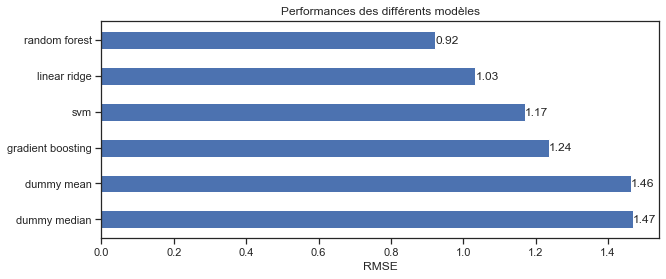

In [265]:
names = ["dummy mean", "dummy median", "linear ridge", "random forest", "gradient boosting", "svm"]
values = [rmse_mean, rmse_median, rmse_lr, rmse_rf, rmse_gb, rmse_svm]

indices = np.argsort(values)[::-1]

x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])

fig, ax = plt.subplots(figsize=(10, 4))    
width = 0.50 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, x, width)
ax.set_yticks(ind)
ax.set_yticklabels(y, minor=False)
plt.title('Performances des différents modèles')
plt.xlabel("RMSE")
for i, v in enumerate(x):
    ax.text(v, i-.1, str(round(v,2)))

plt.show()

Runtime Mean DummyRegressor : 0.0 s
Runtime Median DummyRegressor : 0.0010232925415039062 s
Runtime Linear Regression ridge : 0.003962516784667969 s
Runtime Random Forest : 0.29122090339660645 s
Runtime Gradient Boosting : 7.546828508377075 s
Runtime SVM Regressor : 0.7639827728271484 s


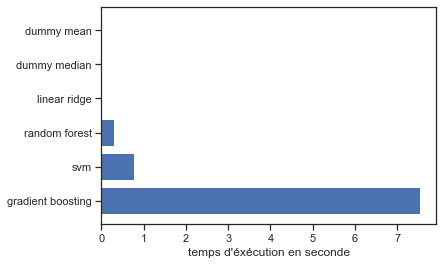

In [266]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
dum_mean = dummy.DummyRegressor(strategy='mean')
dum_mean.fit(X_train, y_train)
y_pred_mean = dum_mean.predict(X_test)
time_mean = time.time() - start_time
rmse_mean = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))
print("Runtime Mean DummyRegressor : {} s".format(time_mean, rmse_mean))

start_time = time.time()
dum_median = dummy.DummyRegressor(strategy='median')
dum_median.fit(X_train, y_train)
y_pred_median = dum_median.predict(X_test)
time_median = time.time() - start_time
rmse_median = np.sqrt(metrics.mean_squared_error(y_test, y_pred_median))
print("Runtime Median DummyRegressor : {} s".format(time_median, rmse_median))

start_time = time.time()
lr = linear_model.Ridge(alpha=lrp).fit(X_train, y_train)
y_pred_linear = lr.predict(X_test)
time_lr = time.time() - start_time
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear))
print("Runtime Linear Regression ridge : {} s".format(time_lr, rmse_lr))

start_time = time.time()
rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
time_rf = time.time() - start_time
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
print("Runtime Random Forest : {} s".format(time_rf, rmse_rf))

start_time = time.time()
gbr = GradientBoostingRegressor(n_estimators = gbparam1, max_depth=gbparam2,learning_rate=gbparam3,
                                loss='ls').fit(X_train, y_train)
y_pred_gb = gbr.predict(X_test)
time_gb = time.time() - start_time
rmse_gb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb))
print("Runtime Gradient Boosting : {} s".format(time_gb, rmse_gb))

start_time = time.time()
svm = SVR(kernel="rbf", C=svmparam1, gamma=svmparam2).fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
time_svm = time.time() - start_time
rmse_svm = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svm))
print("Runtime SVM Regressor : {} s".format(time_svm, rmse_svm))

names = ["dummy mean", "dummy median", "linear ridge", "random forest", "gradient boosting", "svm"]
values = [time_mean, time_median, time_lr, time_rf, time_gb, time_svm]

indices = np.argsort(values)[::-1]
x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])

plt.xlabel("temps d'éxécution en seconde")
plt.barh(y, x)
plt.show()

Feature ranking:
1. feature:NaturalGas(kBtu) (0.199218)
2. feature:NumberofFloors (0.179517)
3. feature:SteamUse(kBtu) (0.079309)
4. feature:YearBuilt (0.058828)
5. feature:ENERGYSTARScore (0.056741)
6. feature:ListOfAllPropertyUseTypes (0.054612)
7. feature:Address (0.050955)
8. feature:PropertyName (0.046528)
9. feature:OH10 (0.045860)
10. feature:LargestPropertyUseType (0.044481)
11. feature:TaxParcelIdentificationNumber (0.044031)
12. feature:ZipCode (0.030360)
13. feature:OH25 (0.020605)
14. feature:NumberofBuildings (0.020341)
15. feature:OH24 (0.014023)


<BarContainer object of 15 artists>

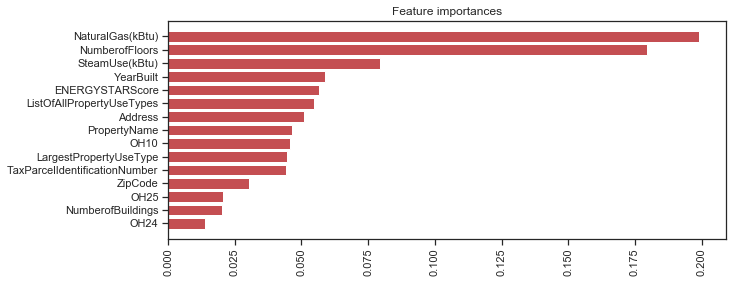

In [270]:
#importance des features
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0).fit(X_train, y_train)

feature_importances = rf.feature_importances_

indices = np.argsort(feature_importances)[-15:]

# Print the feature ranking
print("Feature ranking:")
j = 1
x = []
y = []
for i in reversed(list(indices)):
    y.append(feature_importances[i])
    x.append(list(X_train.columns)[i])
    print("%d. feature:%s (%f)" % (j, list(X_train.columns)[i], feature_importances[i]))
    j += 1
x.reverse()
y.reverse()
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)
plt.title("Feature importances")
plt.barh(x, y, color="r", align='center')

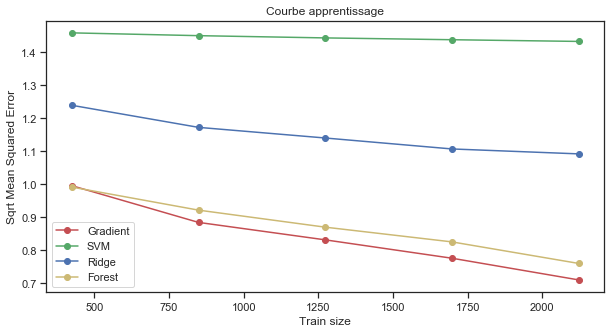

In [277]:
#Courbe d'apprentissage
X_train = bunch_train.copy()
X_test =  bunch_test.copy()
#bunch = pd.concat([bunch_train, bunch_test], axis=0, join='inner', ignore_index=True)
#y = df["TotalGHGEmissions"]

lr = linear_model.Ridge(alpha=lrp)
rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0)
gbr = GradientBoostingRegressor(n_estimators = gbparam1, max_depth=gbparam2, learning_rate=gbparam3,
                                loss='ls')
svm = SVR(kernel="rbf", C=svmparam1, gamma=svmparam2)

train_sizes, train_scores_gbr, test_scores_gbr =  learning_curve(gbr, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_svm, train_scores_svm, test_scores_svm =  learning_curve(svm, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_lr, train_scores_lr, test_scores_lr =  learning_curve(lr, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_rf, train_scores_rf, test_scores_rf =  learning_curve(rf, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)

scores_gbr = np.sqrt(-test_scores_gbr.mean(1))
scores_svm = np.sqrt(-test_scores_svm.mean(1))
scores_lr = np.sqrt(-test_scores_lr.mean(1))
scores_rf = np.sqrt(-test_scores_rf.mean(1))

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, scores_gbr, 'o-', color="r", label="Gradient")
plt.plot(train_sizes, scores_svm, 'o-', color="g", label="SVM")
plt.plot(train_sizes, scores_lr, 'o-', color="b", label="Ridge")
plt.plot(train_sizes, scores_rf, 'o-', color="y", label="Forest")

#scores = np.sqrt(-train_scores_gbr.mean(1))
#plt.plot(train_sizes, scores, 'o-', color="g")
plt.xlabel("Train size")
plt.ylabel("Sqrt Mean Squared Error")
plt.title('Courbe apprentissage')
plt.legend(loc="best")

plt.show()

In [278]:
############################################# Consommation totale d'énergie ##################################################

In [279]:
df = df_breakpoint.copy()

In [280]:
print(df[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]].skew())

TotalGHGEmissions      14.185609
SiteEnergyUse(kBtu)    17.501283
dtype: float64


In [281]:
for f in ["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]:
    df[f] = np.log1p(df[f])

In [282]:
print(df[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]].skew())

TotalGHGEmissions      0.155362
SiteEnergyUse(kBtu)   -3.320828
dtype: float64


In [283]:
y = df["SiteEnergyUse(kBtu)"]
X = df.drop(["SiteEnergyUse(kBtu)", "OSEBuildingID", "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)",
             "GHGEmissionsIntensity", "TotalGHGEmissions"], axis=1)

In [284]:
#Transformer les valeurs de la variable DefaultData: True par 1 et False par 0
X.loc[X["DefaultData"] == "True", "DefaultData"] = 1
X.loc[X["DefaultData"] == "False", "DefaultData"] = 0
X["DefaultData"] = X["DefaultData"].astype("float64")

#traiter les variables Electricity, NaturalGas, SteamUse comme binaire; 1 si val > 0 et 0 sinon
X.loc[X["SteamUse(kBtu)"] > 0, "SteamUse(kBtu)"] = 1
X.loc[X["Electricity(kBtu)"] > 0, "Electricity(kBtu)"] = 1
X.loc[X["NaturalGas(kBtu)"] > 0, "NaturalGas(kBtu)"] = 1

In [285]:
X_train = X[:SIZE]
X_test = X[SIZE:]
y_train = y[:SIZE]
y_test = y[SIZE:]

In [286]:
bunch_train = X_train[numerical_cols]
bunch_test =  X_test[numerical_cols]

In [287]:
bunch_train.head()

,DefaultData,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Longitude,Latitude
0,0.0,4.0,1948.0,1.0,1.0,0.0,22778.0,21194.0,12923.0,3720.0,72.0,0.0,1.0,1.0,-122.276776,47.66811
1,0.0,6.0,2000.0,1.0,4.0,36528.0,53472.0,90000.0,11737.0,5837.0,84.0,0.0,1.0,0.0,-122.351580,47.64963
2,0.0,2.0,1963.0,1.0,1.0,0.0,100386.0,50628.0,49758.0,5837.0,72.0,0.0,1.0,1.0,-122.327410,47.56819
3,0.0,7.0,1947.0,1.0,2.0,0.0,22612.0,22612.0,11737.0,5837.0,87.0,0.0,1.0,1.0,-122.403200,47.63927
4,0.0,7.0,1914.0,1.0,4.0,0.0,45500.0,45500.0,11737.0,5837.0,77.0,1.0,1.0,1.0,-122.335200,47.60154


In [288]:
#Label encoder
X_tr = X_train.copy()
X_te = X_test.copy()

label_encoder = LabelEncoder()

for col in categorical_cols_label:
    bunch_train[col] = label_encoder.fit_transform(X_tr[col])
    lists_enc = list(label_encoder.classes_)
    lists_enc_not = []
    for i, row in X_te.iterrows():
        val = X_te.loc[i, col] 
        if val not in lists_enc:
            lists_enc_not.append(val)    
    label_encoder.classes_ = np.array(lists_enc + lists_enc_not)
    bunch_test[col] = label_encoder.transform(X_te[col])

C:\Users\namat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\namat\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [289]:
bars = {"Linear regressor Ridge" : [], "SVM regressor": [], "Random Forest Regressor": [],
        "Gradient Boosting Regressor": [], "Total moyen": []}

In [290]:
import time
X_tr = bunch_train.join(X_train[categorical_cols_other])
X_te = bunch_test.join(X_test[categorical_cols_other])

#one hot encoding
sum_error = 0
errors = []
start_time = time.time()
i = 0
for model in models:
    my_pipeline = Pipeline(steps=[('encoder', OH_encoder), ('model', model)])
    my_pipeline.fit(X_tr, y_train)
    y_preds = my_pipeline.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps total d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps total d'execution : 2.5482187271118164 secondes
RMSE : 1.0867896007410924


In [291]:
#Count encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

d = pd.concat([ixtr[categorical_cols_other],ixte[categorical_cols_other]], 
              axis=0, join='inner', ignore_index=True)#fusion des lignes des variables à encoder

d2 = pd.concat([bxtr, bxte], axis=0, join='inner', ignore_index=True)#fusion des bunchs train et test

start_time = time.time()
count_encoded = CE_encoder.fit_transform(d[categorical_cols_other])

data = d2.join(count_encoded.add_suffix("_count")) 

X_tr = data[:SIZE]
X_te = data[SIZE:]

sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d'execution : 0.956475019454956 secondes
RMSE : 1.1002203256353802


In [292]:
#Target encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

start_time = time.time()

TE_encoder.fit(ixtr[categorical_cols_other], y_train)

X_tr = bxtr.join(TE_encoder.transform(ixtr[categorical_cols_other]).add_suffix('_target'))
X_te = bxte.join(TE_encoder.transform(ixte[categorical_cols_other]).add_suffix('_target'))

#print(target_encoded_train)
sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d'execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d'execution : 1.0561752319335938 secondes
RMSE : 1.0502186180595765


In [293]:
#CatBoost encoding
ixtr = X_train.copy()
ixte = X_test.copy()
bxtr = bunch_train.copy()
bxte = bunch_test.copy()

start_time = time.time()

CatB_encode.fit(ixtr[categorical_cols_other], y_train)
X_tr = bxtr.join(CatB_encode.transform(ixtr[categorical_cols_other]).add_suffix('_CB'))
X_te = bxte.join(CatB_encode.transform(ixte[categorical_cols_other]).add_suffix('_CB'))

sum_error = 0
errors = []
i = 0
for model in models:
    model.fit(X_tr, y_train)
    y_preds = model.predict(X_te)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
    errors.append(error)
    sum_error += error
    bars[model_names[i]].append(error)
    i += 1
error_encoding = sum_error/len(models)
errors_encoding.append(error_encoding)
print("Temps d execution : %s secondes" % (time.time() - start_time))
bars["Total moyen"].append(error_encoding)
print("RMSE : {}".format(error_encoding))

Temps d execution : 1.1587717533111572 secondes
RMSE : 1.0386760721625379


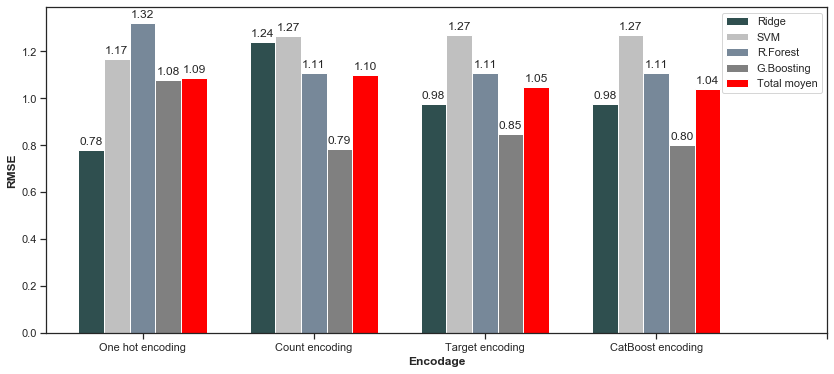

In [294]:
fig, ax = plt.subplots(figsize=(14, 6))
barWidth = 0.15
r1 = np.arange(4)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

rects1 = ax.bar(r1, bars[model_names[0]], color="#2F4F4F", width=barWidth, edgecolor='white', label="Ridge")
rects2 = ax.bar(r2, bars[model_names[1]], color='#C0C0C0', width=barWidth, edgecolor='white', label="SVM")
rects3 = ax.bar(r3, bars[model_names[2]], color='#778899', width=barWidth, edgecolor='white', label="R.Forest")
rects4 = ax.bar(r4, bars[model_names[3]], color='#808080', width=barWidth, edgecolor='white', label="G.Boosting")
rects5 = ax.bar(r5, bars["Total moyen"], color='red', width=barWidth, edgecolor='white', label="Total moyen")


# Add xticks on the middle of the group bars
ax.set_xlabel('Encodage', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_xticks([r + barWidth*2 for r in range(5)])
ax.set_xticklabels(['One hot encoding', 'Count encoding', 'Target encoding', 'CatBoost encoding'])
 
# Create legend & Show graphic
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f'%height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

In [295]:
#ajout le meilleur encodage
X_tr = X_train.copy()[categorical_cols_other]
X_te = X_test.copy()[categorical_cols_other]

CatB_encode.fit(X_tr, y_train)
bunch_train = bunch_train.join(CatB_encode.transform(ixtr[categorical_cols_other]).add_suffix('_CB'))
bunch_test = bunch_test.join(CatB_encode.transform(X_te).add_suffix('_CB'))

In [296]:
bunch_train.shape

(2654, 28)

In [297]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

#definir les modèles baselines
start_time = time.time()
dum_mean = dummy.DummyRegressor(strategy='mean')
my_pipeline = Pipeline(steps=[('preprocessor', std), ('model', dum_mean)])
my_pipeline.fit(X_train, y_train)
y_pred_mean = my_pipeline.predict(X_test)
rmse_mean = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))
time_mean = time.time() - start_time

start_time = time.time()
dum_median = dummy.DummyRegressor(strategy='median')
my_pipeline2 = Pipeline(steps=[('preprocessor', std), ('model', dum_median)])
my_pipeline2.fit(X_train, y_train)
y_pred_median = my_pipeline2.predict(X_test)
rmse_median = np.sqrt(metrics.mean_squared_error(y_test, y_pred_median))
time_median = time.time() - start_time

print("RMSE Mean DummyRegressor: %.2f, runtime: %.2fs" % (rmse_mean, time_mean))
print("RMSE Median DummyRegressor: %.2f, runtime: %.2fs" % (rmse_median, time_median))

RMSE Mean DummyRegressor: 1.67, runtime: 0.00s
RMSE Median DummyRegressor: 1.68, runtime: 0.00s


In [301]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_ridge = {'alpha':np.logspace(-2, 2, 10)}
lr = linear_model.Ridge()#linear regression ridge
grid_pred_ridge = model_selection.GridSearchCV(lr, param_grid_ridge, cv=5)

my_pipeline3 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_ridge)])

my_pipeline3.fit(X_train, y_train)

y_pred_linear = my_pipeline3.predict(X_test)

rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear))
time_lr = time.time() - start_time

#récupération des paramètres
lrp = grid_pred_ridge.best_params_["alpha"]

print("RMSE Linear Regression ridge: %.2f, runtime: %.2fs" % (rmse_lr, time_lr))
print("Best params : {}".format(grid_pred_ridge.best_params_))

RMSE Linear Regression ridge: 0.97, runtime: 0.16s
Best params : {'alpha': 100.0}


In [307]:
X_train = bunch_train.copy()
X_test = bunch_test.copy()

start_time = time.time()
param_grid_rd = {'max_depth' : np.arange(12,14), 'n_estimators' : np.arange(100, 1200, 500)}
rf = RandomForestRegressor(random_state=0)#random Forest regressor
grid_pred_rf = model_selection.GridSearchCV(rf, param_grid_rd, cv=5)

my_pipeline4 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_rf)])

my_pipeline4.fit(X_train, y_train)

y_pred_rf = my_pipeline4.predict(X_test)

rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
time_rf = time.time() - start_time

#récupération des paramètres
rfparam1 = grid_pred_rf.best_params_["max_depth"]
rfparam2 = grid_pred_rf.best_params_["n_estimators"]

print("RMSE Random Forest: %.2f, runtime: %.2fs" % (rmse_rf, time_rf))
print("Best params : {}".format(grid_pred_rf.best_params_))

RMSE Random Forest: 0.63, runtime: 240.11s
Best params : {'max_depth': 13, 'n_estimators': 100}


In [313]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_gb ={'n_estimators': np.arange(2000, 4500, 500), 'max_depth' : np.arange(2,5), "learning_rate" : [0.05]}
gb = GradientBoostingRegressor(loss='ls')#Gradient boosting regressor
grid_pred_gb = model_selection.GridSearchCV(gb, param_grid_gb, cv=5)

my_pipeline5 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_gb)])

my_pipeline5.fit(X_train, y_train)

y_pred_gb = my_pipeline5.predict(X_test)

rmse_gb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb))
time_gb = time.time() - start_time

#récupération des paramètres
gbparam1 = grid_pred_gb.best_params_["n_estimators"]
gbparam2 = grid_pred_gb.best_params_["max_depth"]
gbparam3 = grid_pred_gb.best_params_["learning_rate"]

print("RMSE Gradient Boosting: %.2f, runtime: %2.fs" % (rmse_gb, time_gb))
print("Best params : {}".format(grid_pred_gb.best_params_))

RMSE Gradient Boosting: 1.22, runtime: 464s
Best params : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 3000}


In [317]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
param_grid_svm ={'C' : [1e0, 1e1, 1e2, 1e3], 'gamma': np.logspace(-2, 2, 5)}
svm = SVR(kernel="rbf")#SVM regressor
grid_pred_svm = model_selection.GridSearchCV(svm, param_grid_svm, cv=5)

my_pipeline6 = Pipeline(steps=[('preprocessor', std), ('model', grid_pred_svm)])

my_pipeline6.fit(X_train, y_train)

y_pred_svm = my_pipeline6.predict(X_test)

rmse_svm = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svm))
time_svm = time.time() - start_time

#récupération des paramètres
svmparam1 = grid_pred_svm.best_params_["C"]
svmparam2 = grid_pred_svm.best_params_["gamma"]

print("RMSE SVM Regressor: %.2f, runtime: %2.fs" % (rmse_svm, time_svm))
print("Best params : {}".format(grid_pred_svm.best_params_))

RMSE SVM Regressor: 0.86, runtime: 94s
Best params : {'C': 100.0, 'gamma': 0.01}


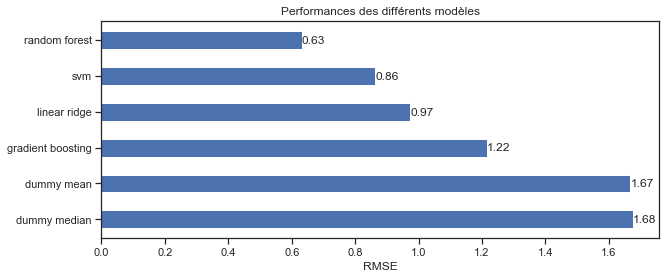

In [318]:
names = ["dummy mean", "dummy median", "linear ridge", "random forest", "gradient boosting", "svm"]
values = [rmse_mean, rmse_median, rmse_lr, rmse_rf, rmse_gb, rmse_svm]

indices = np.argsort(values)[::-1]
x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])
    
fig, ax = plt.subplots(figsize=(10, 4))    
width = 0.50 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, x, width)
ax.set_yticks(ind)
ax.set_yticklabels(y, minor=False)
plt.title('Performances des différents modèles')
plt.xlabel("RMSE")
for i, v in enumerate(x):
    ax.text(v, i-.1, str(round(v,2)))

Runtime Mean DummyRegressor : 0.0009989738464355469 s
Runtime Median DummyRegressor : 0.0009961128234863281 s
Runtime Linear Regression ridge : 0.0029671192169189453 s
Runtime Random Forest : 0.32715535163879395 s
Runtime Gradient Boosting : 7.110992670059204 s
Runtime SVM Regressor : 0.8028693199157715 s


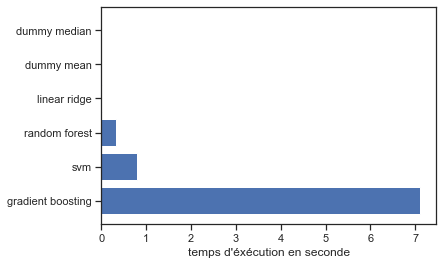

In [320]:
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

start_time = time.time()
dum_mean = dummy.DummyRegressor(strategy='mean')
dum_mean.fit(X_train, y_train)
y_pred_mean = dum_mean.predict(X_test)
time_mean = time.time() - start_time
rmse_mean = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))
print("Runtime Mean DummyRegressor : {} s".format(time_mean, rmse_mean))

start_time = time.time()
dum_median = dummy.DummyRegressor(strategy='median')
dum_median.fit(X_train, y_train)
y_pred_median = dum_median.predict(X_test)
time_median = time.time() - start_time
rmse_median = np.sqrt(metrics.mean_squared_error(y_test, y_pred_median))
print("Runtime Median DummyRegressor : {} s".format(time_median, rmse_median))

start_time = time.time()
lr = linear_model.Ridge(alpha=lrp).fit(X_train, y_train)
y_pred_linear = lr.predict(X_test)
time_lr = time.time() - start_time
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear))
print("Runtime Linear Regression ridge : {} s".format(time_lr, rmse_lr))

start_time = time.time()
rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
time_rf = time.time() - start_time
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
print("Runtime Random Forest : {} s".format(time_rf, rmse_rf))

start_time = time.time()
gbr = GradientBoostingRegressor(n_estimators = gbparam1, max_depth=gbparam2, learning_rate=gbparam3,
                                loss='ls').fit(X_train, y_train)
y_pred_gb = gbr.predict(X_test)
time_gb = time.time() - start_time
rmse_gb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb))
print("Runtime Gradient Boosting : {} s".format(time_gb, rmse_gb))

start_time = time.time()
svm = SVR(kernel="rbf", C=svmparam1, gamma=svmparam2).fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
time_svm = time.time() - start_time
rmse_svm = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svm))
print("Runtime SVM Regressor : {} s".format(time_svm, rmse_svm))

names = ["dummy mean", "dummy median", "linear ridge", "random forest", "gradient boosting", "svm"]
values = [time_mean, time_median, time_lr, time_rf, time_gb, time_svm]

indices = np.argsort(values)[::-1]
x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])

plt.xlabel("temps d'éxécution en seconde")
plt.barh(y, x)
plt.show()

Feature ranking:
1. feature:ComplianceStatus_CB (0.339715)
2. feature:PropertyGFABuilding(s) (0.303867)
3. feature:PrimaryPropertyType_CB (0.080504)
4. feature:Electricity(kBtu) (0.063953)
5. feature:LargestPropertyUseTypeGFA (0.049329)
6. feature:ENERGYSTARScore (0.036161)
7. feature:YearBuilt (0.014863)
8. feature:NaturalGas(kBtu) (0.013220)
9. feature:Longitude (0.011257)
10. feature:PropertyName (0.009598)
11. feature:LargestPropertyUseType (0.009034)
12. feature:ListOfAllPropertyUseTypes (0.008614)
13. feature:Address (0.008239)
14. feature:SecondLargestPropertyUseTypeGFA (0.008147)
15. feature:Latitude (0.006952)


<BarContainer object of 15 artists>

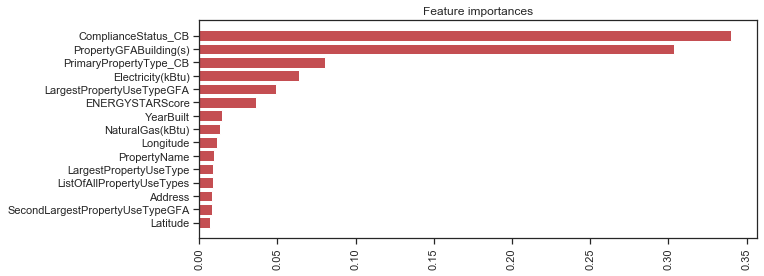

In [322]:
#importance des features
X_train = bunch_train.copy()
X_test =  bunch_test.copy()

rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0).fit(X_train, y_train)

feature_importances = rf.feature_importances_

indices = np.argsort(feature_importances)[-15:]

# Print the feature ranking
print("Feature ranking:")
j = 1
x = []
y = []
for i in reversed(list(indices)):
    x.append(list(X_train.columns)[i])
    y.append(feature_importances[i])
    print("%d. feature:%s (%f)" % (j, list(X_train.columns)[i], feature_importances[i]))
    j += 1

x.reverse()
y.reverse()
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)
plt.title("Feature importances")
plt.barh(x, y, color="r", align='center')

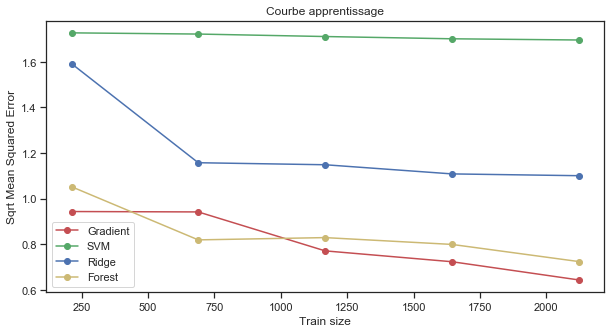

In [324]:
#Courbe d'apprentissage
X_train = bunch_train.copy()
X_test =  bunch_test.copy()
#bunch = pd.concat([bunch_train, bunch_test], axis=0, join='inner', ignore_index=True)
#y = df["SiteEnergyUse(kBtu)"]

lr = linear_model.Ridge(alpha=lrp)
rf = RandomForestRegressor(n_estimators=rfparam1, max_depth=rfparam2,  random_state=0)
gbr = GradientBoostingRegressor(n_estimators = gbparam1, max_depth=gbparam2, learning_rate=gbparam3,
                                loss='ls')
svm = SVR(kernel="rbf", C=svmparam1, gamma=svmparam2)

train_sizes, train_scores_gbr, test_scores_gbr =  learning_curve(gbr, X_train, y_train, train_sizes=np.linspace(0.1, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_svm, train_scores_svm, test_scores_svm =  learning_curve(svm, X_train, y_train, train_sizes=np.linspace(0.1, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_lr, train_scores_lr, test_scores_lr =  learning_curve(lr, X_train, y_train, train_sizes=np.linspace(0.1, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)
train_sizes_rf, train_scores_rf, test_scores_rf =  learning_curve(rf, X_train, y_train, train_sizes=np.linspace(0.1, 1, 5), 
                                                                 scoring="neg_mean_squared_error", cv=5)

scores_gbr = np.sqrt(-test_scores_gbr.mean(1))
scores_svm = np.sqrt(-test_scores_svm.mean(1))
scores_lr = np.sqrt(-test_scores_lr.mean(1))
scores_rf = np.sqrt(-test_scores_rf.mean(1))

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, scores_gbr, 'o-', color="r", label="Gradient")
plt.plot(train_sizes, scores_svm, 'o-', color="g", label="SVM")
plt.plot(train_sizes, scores_lr, 'o-', color="b", label="Ridge")
plt.plot(train_sizes, scores_rf, 'o-', color="y", label="Forest")

#scores = np.sqrt(-train_scores_gbr.mean(1))
#plt.plot(train_sizes, scores, 'o-', color="g")
plt.xlabel("Train size")
plt.ylabel("Sqrt Mean Squared Error")
plt.title('Courbe apprentissage')
plt.legend(loc="best")

plt.show()